# Project Planning

- Describe the project and goals.

- Task out how you will work through the pipeline in as much detail as you need to keep on track.

- Incluce a data dictionary.

- Clearly state your starting hypotheses (and add the testing of these to your task list).

## Goals

- Find drivers for customer churn.

- Construct a ML classification model that accurately predicts customer churn.

- Create modules that make your process repeateable.

- Document your process well enough to be presented or read like a report.



## Audience

- Your target audience for your notebook walkthrough is the Codeup Data Science team. This should guide your language and level of explanations in your walkthrough.

### Project Specifications

#### Why are our customers churning?

###### Some questions to think about include but are not limited to:

- Are there clear groupings where a customer is more likely to churn?

    - What if you consider contract type?
    - Is there a tenure that month-to-month customers are most likely to churn? 
        - 1-year contract customers? 
        - 2-year contract customers?
    - Do you have any thoughts on what could be going on? (Be sure to state these thoughts not as facts but as untested hypotheses. Unless you test them!). Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).

- Are there features that indicate a higher propensity to churn?

    - How influential are type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

- Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point?

    - If so, what is that point and for which service(s)?

    - If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?


## Acquisition

- Acquire data from the customers table from the telco_churn database on the codeup data science database server.

- You will want to join some tables as part of your query.

- This data should end up in a pandas data frame.

- summarize data (.info(), .describe(), .value_counts(), ...)

- plot distributions of individual variables



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from acquire import get_telco_data

In [2]:
#grabbing telco data from SQL using function and storing it as a DataFrame
df = pd.DataFrame(get_telco_data())
df = df.set_index('customer_id')

In [3]:
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,2,1,1,Male,0,No,No,9,Yes,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
0013-MHZWF,4,1,1,Female,0,No,Yes,9,Yes,No,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
0015-UOCOJ,1,1,1,Female,1,No,No,7,Yes,No,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
0023-HGHWL,1,1,1,Male,1,No,No,1,No,No phone service,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
0032-PGELS,3,1,1,Female,0,Yes,Yes,1,No,No phone service,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0003-MKNFE to 9975-GPKZU
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   gender                    7043 non-null   object 
 4   senior_citizen            7043 non-null   int64  
 5   partner                   7043 non-null   object 
 6   dependents                7043 non-null   object 
 7   tenure                    7043 non-null   int64  
 8   phone_service             7043 non-null   object 
 9   multiple_lines            7043 non-null   object 
 10  online_security           7043 non-null   object 
 11  online_backup             7043 non-null   object 
 12  device_protection         7043 non-null   object 
 13  tech_support              7043 non-null   object 
 14

__All of the columns do not have any null values.__

__Multiple columns are object that need to be changed to numeric values.__

__There are duplicate columns from grabbing all the available data.__

In [5]:
df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


__There does not seem to be any outliers__

In [6]:
df.payment_type_id.value_counts()

1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64

- 1: electronic check
    - has the most
- 2: mailed check
- 3: bank transfer(automatic)
- 4: credit card(automatic)
    - others are relatively the same

In [7]:
df.internet_service_type_id.value_counts()

2    3096
1    2421
3    1526
Name: internet_service_type_id, dtype: int64

- 1: DSL
    - between 6-700 fewer than fiber
- 2: Fiber Optic
    - has the most customers
- 3: None
    - around 20% of customers dont have internet

In [8]:
df.contract_type_id.value_counts()

1    3875
3    1695
2    1473
Name: contract_type_id, dtype: int64

- 1: Month-to-month
    - more than double the amount of the other 2 combined
- 2: 1 year
    - has the least but not by much
- 3: 2 year
    - second highest category

In [9]:
df.senior_citizen.value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

- 0: Is not senior citizen
    - majority of customers
- 1: Is senior citizen

In [10]:
df.phone_service.value_counts()

Yes    6361
No      682
Name: phone_service, dtype: int64

- almost everyone has a phone service

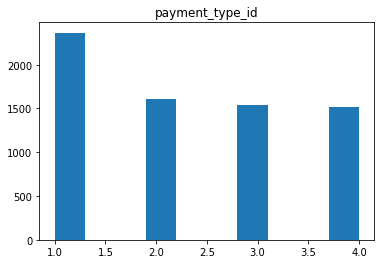

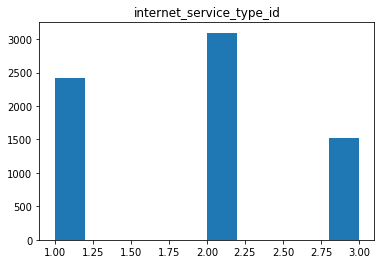

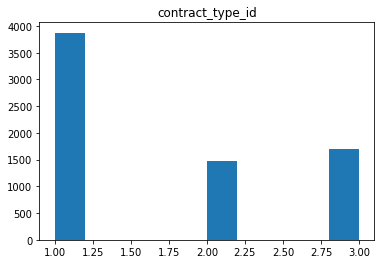

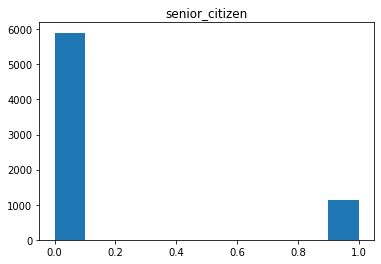

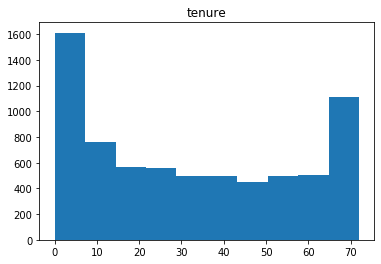

In [11]:
# distribution of columns whose data type is 'int64'
num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

a lot of new customers and a lot of old customers with a steady amount in between

## Data Prep

- Change device_protection, tech_support and papperless_billing to 0/1

- Create a new feature that represents tenure in years.

- Create single variables for or find other methods to merge variables representing the information from the following columns:

    - phone_service and multiple_lines
    - dependents and partner
    - streaming_tv & streaming_movies
    - online_security & online_backup
    
- Split your data into train/validate/test.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
rows_to_drop = ([6895, 6686, 6615, 6605, 6569, 6143, 2132, 2048, 2029, 1949, 1878])

In [14]:
df.drop(df.index[rows_to_drop], inplace = True)

In [15]:
df.total_charges = pd.to_numeric(df.total_charges)

In [16]:
def online_checker(row):
        if row == 'Yes':
            return 1
        else:
            return 0

In [17]:
df.device_protection = df.device_protection.apply(online_checker)

In [18]:
df.tech_support = df.tech_support.apply(online_checker)

In [19]:
df.online_security = df.online_security.apply(online_checker)

In [20]:
df.online_backup = df.online_backup.apply(online_checker)

In [21]:
df.streaming_tv = df.streaming_tv.apply(online_checker)

In [22]:
df.streaming_movies = df.streaming_movies.apply(online_checker)

In [23]:
df.multiple_lines = df.multiple_lines.apply(online_checker)

In [24]:
df['tenure_by_year'] = round(df.tenure / 12, 2)

In [25]:
telco_dummies = pd.get_dummies(df[['gender', 'partner', 'dependents', 'phone_service', 'churn', 'paperless_billing']], drop_first=True)

In [26]:
internet_dummie = pd.get_dummies(df['internet_service_type_id'])

In [27]:
internet_dummie = internet_dummie.rename(columns = {1:'DSL', 2:'Fiber', 3:'No_internet'})

In [28]:
payment_dummie = pd.get_dummies(df['payment_type_id'])

In [29]:
payment_dummie = payment_dummie.rename(columns = {1: 'echeck', 2: 'mailed_check', 3: 'bank_transfer', 4:'credit_card'})

In [30]:
contract_dummie = pd.get_dummies(df['contract_type_id'])

In [31]:
contract_dummie = contract_dummie.rename(columns = {1:'Month2month', 2:'1year', 3:'2year'})

In [32]:
df = pd.concat([df, telco_dummies, payment_dummie, contract_dummie], axis=1)

In [33]:
col_to_drop = ['payment_type_id', 'gender', 'partner', 'dependents', 'phone_service', 'churn', 'paperless_billing', 'contract_type', 'internet_service_type', 'payment_type']

In [34]:
df = df.drop(columns = col_to_drop)

In [35]:
def telco_split(df):

    train_validate, test = train_test_split(df, test_size=.15, 
                                        random_state=123, 
                                        stratify=df.churn_Yes)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn_Yes)
    return train, validate, test

In [36]:
train, validate, test = telco_split(df)

In [37]:
train.shape, validate.shape, test.shape

((4183, 27), (1794, 27), (1055, 27))

In [38]:
train.head().T

customer_id,1345-GKDZZ,5982-FPVQN,7305-ZWMAJ,1173-NOEYG,0228-MAUWC
internet_service_type_id,3.00,2.00,3.0,2.00,1.00
contract_type_id,1.00,1.00,2.0,1.00,1.00
senior_citizen,0.00,0.00,0.0,0.00,0.00
tenure,6.00,37.00,30.0,27.00,19.00
multiple_lines,0.00,1.00,0.0,1.00,1.00
online_security,0.00,0.00,0.0,0.00,0.00
online_backup,0.00,1.00,0.0,0.00,0.00
device_protection,0.00,1.00,0.0,1.00,1.00
tech_support,0.00,0.00,0.0,0.00,1.00
streaming_tv,0.00,0.00,0.0,0.00,0.00


In [39]:
def prep_telco_data(cached = True):
    # use my acquire function to read data into a df from a csv file
    df = pd.DataFrame(get_telco_data())
    #set index as customer_id
    df = df.set_index('customer_id')
    #rows full of Nan values
    rows_to_drop = ([6895, 6686, 6615, 6605, 6569, 6143, 2132, 2048, 2029, 1949, 1878])
    #dropping the Nan values
    df.drop(df.index[rows_to_drop], inplace = True)
    #changing data type of total charges to float
    df.total_charges = pd.to_numeric(df.total_charges)
    # change device_protection into numeric values
    df.device_protection = df.device_protection.apply(online_checker)
    # change tech_suppport into numeric values
    df.tech_support = df.tech_support.apply(online_checker)
    # change online security into numeric values
    df.online_security = df.online_security.apply(online_checker)
    #change online backup into numeric values
    df.online_backup = df.online_backup.apply(online_checker)
    #change streaming tv into numeric values
    df.streaming_tv = df.streaming_tv.apply(online_checker)
    #change streaming movies into numeric values
    df.streaming_movies = df.streaming_movies.apply(online_checker)
    #change multiple lines into numeric values
    df.multiple_lines = df.multiple_lines.apply(online_checker)
    #create a new column with tenure by the year
    df['tenure_by_year'] = df.tenure / 12
    #change multiple_lines into a numeric value
    df.multiple_lines = df.multiple_lines.apply(online_checker)
    #create dummy values for gender, churn, and paperless_billing
    telco_dummies = pd.get_dummies(df[['gender', 'partner', 'dependents', 'phone_service', 'churn', 'paperless_billing']], drop_first=True)
    #create dummy values for internet
    internet_dummie = pd.get_dummies(df['internet_service_type_id'])
    #rename the dummy columns
    internet_dummie = internet_dummie.rename(columns = {1:'DSL', 2:'Fiber', 3:'No_internet'})
    #create dummy variable for payment
    payment_dummie = pd.get_dummies(df['payment_type_id'])
    #rename the dummy columns
    payment_dummie = payment_dummie.rename(columns = {1: 'echeck', 2: 'mailed_check', 3: 'bank_transfer', 4:'credit_card'})
    #create dummy variable for contract type
    contract_dummie = pd.get_dummies(df['contract_type_id'])
    #rename dummy columns
    contract_dummie = contract_dummie.rename(columns = {1:'Month2month', 2:'1year', 3:'2year'})
    #add dummy values into the main dataframe
    df = pd.concat([df, telco_dummies, payment_dummie, contract_dummie, internet_dummie], axis=1)
    #list duplicate columns
    col_to_drop = ['payment_type_id', 'gender', 'partner', 'dependents', 'phone_service', 'churn', 'paperless_billing', 'contract_type', 'internet_service_type', 'payment_type']
    #drop duplicate columns
    df = df.drop(columns = col_to_drop)
    #split data into train, validate and test subsets
    train, validate, test = telco_split(df)
    return train, validate, test

## Data Exploration


In [40]:
from math import sqrt
from scipy import stats
import seaborn as sns
from pydataset import data
from prepare import prep_telco_data

In [41]:
train, validate, test = prep_telco_data()

In [133]:
train.shape, validate.shape, test.shape

((4183, 31), (1794, 30), (1055, 30))

In [43]:
train.churn_Yes.value_counts()

0    3071
1    1112
Name: churn_Yes, dtype: int64

### Is a customer churning independent from the contract type that they sign?

#### Hypothesis 1
- $H_0$: Customers contract type and churn are __independent__
- $H_a$: Customers contract type and churn are __dependent__

In [44]:
observed = pd.crosstab(train.churn_Yes, train.contract_type_id, margins = True)
observed

contract_type_id,1,2,3,All
churn_Yes,,,,
0,1344,795,932,3071
1,986,101,25,1112
All,2330,896,957,4183


In [45]:
alpha = .05

In [46]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.0928621604097868e-144

__Conclusion__: We reject the null hypothesis. We can say that we have confidence that contract service type and customer churn are dependent. There is a relationship between the two. 

### Is a customer churning independent from the internet type they get?

#### Hypothesis 1
- $H_0$: Customers internet type and churn are __independent__
- $H_a$: Customers internet type and churn are __dependent__

In [47]:
observed2 = pd.crosstab(train.churn_Yes, train.internet_service_type_id, margins = True)
observed2

internet_service_type_id,1,2,3,All
churn_Yes,,,,
0,1144,1077,850,3071
1,258,776,78,1112
All,1402,1853,928,4183


In [48]:
alpha = .05

In [49]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.0928621604097868e-144

__Conclusion__: We reject the null hypothesis. We can say that we have confidence that internet service type and customer churn are dependent. There is a relationship between the two. 

## Modeling and Evaluation

You are required to establish a baseline accuracy to determine if having a model is better than no model and train and compare at least 3 different models. Document these steps well.

In Your Notebook

- Feature Selection: Are there any variables that seem to provide limited to no additional information? If so, remove them.

- Train (fit, transform, evaluate) multiple different models, varying the model type and hyperparameters.

- Compare evaluation metrics across all the models, and select the ones you want to test using your validate dataframe.

- Based on how your evaluation of your models using the train and validate datasets, choose your best model that you will try with your test data.

- Test the final model (transform, evaluate) on your out-of-sample data (the testing data set). Summarize the performance. Interpret your results.

Draw Conclusions

- Summarize your findings.

- Key takeaways and next steps should be documented here.

In [50]:
from model import logistic_regression
from model import decision_tree
from model import random_forest
from model import kneighbors
import warnings
warnings.filterwarnings("ignore")

### Train

In [51]:
X_train = train.drop(columns = ['churn_Yes', 'contract_type_id', 'internet_service_type_id'])
y_train = train[['churn_Yes']]

In [164]:
train['baseline'] = train.churn_Yes.value_counts().index[1]

In [165]:
baseline_accuracy = (train.baseline == train.churn_Yes).mean()
baseline_accuracy

0.2658379153717428

In [166]:
coeff, cm, class_report = logistic_regression(X_train, y_train)

In [167]:
coeff.T

,0
senior_citizen,0.300427
tenure,-0.064190
multiple_lines,0.000000
online_security,-0.476370
online_backup,-0.087425
device_protection,-0.103252
tech_support,-0.466921
streaming_tv,0.037015
streaming_movies,0.098066
monthly_charges,0.005966


In [168]:
cm

,0,1
0,2749,322
1,524,588


In [169]:
class_report

,0,1,accuracy,macro avg,weighted avg
precision,0.839902,0.646154,0.797753,0.743028,0.788397
recall,0.895148,0.528777,0.797753,0.711963,0.797753
f1-score,0.866646,0.581602,0.797753,0.724124,0.790870
support,3071.000000,1112.000000,0.797753,4183.000000,4183.000000


In [58]:
X_train2 = train[['online_security', 'tech_support', 'phone_service_Yes', 'paperless_billing_Yes', 'echeck', 'Month2month', '2year', 'Fiber', 'No_internet']]
y_train2 = train[['churn_Yes']]

In [59]:
coeff2, cm2, class_report2 = logistic_regression(X_train2, y_train2)

In [60]:
coeff2

,online_security,tech_support,phone_service_Yes,paperless_billing_Yes,echeck,Month2month,2year,Fiber,No_internet,intercept
0,-0.624809,-0.392632,-0.384661,0.29776,0.429699,1.346137,-1.119897,0.881686,-0.617564,-1.992


In [61]:
cm2

,0,1
0,2695,376
1,525,587


In [62]:
class_report2

,0,1,accuracy,macro avg,weighted avg
precision,0.836957,0.609553,0.784604,0.723255,0.776504
recall,0.877564,0.527878,0.784604,0.702721,0.784604
f1-score,0.856780,0.565783,0.784604,0.711281,0.779422
support,3071.000000,1112.000000,0.784604,4183.000000,4183.000000


In [270]:
cm3, class_report3 = decision_tree(X_train2, y_train2, 3)

In [271]:
cm3

,0,1
0,2623,448
1,498,614


In [272]:
class_report3

,0,1,accuracy,macro avg,weighted avg
precision,0.840436,0.578154,0.773847,0.709295,0.770711
recall,0.854119,0.552158,0.773847,0.703139,0.773847
f1-score,0.847222,0.564857,0.773847,0.706040,0.772159
support,3071.000000,1112.000000,0.773847,4183.000000,4183.000000


In [273]:
cm4, class_report4 = random_forest(X_train2, y_train2, 150, 4)

In [274]:
cm4

,0,1
0,2825,246
1,683,429


In [276]:
class_report4

,0,1,accuracy,macro avg,weighted avg
precision,0.805302,0.635556,0.777911,0.720429,0.760177
recall,0.919896,0.385791,0.777911,0.652844,0.777911
f1-score,0.858793,0.480134,0.777911,0.669464,0.758131
support,3071.000000,1112.000000,0.777911,4183.000000,4183.000000


In [277]:
cm5, class_report5 = kneighbors(X_train2, y_train2, 3)

In [278]:
cm5

,0,1
0,2578,493
1,746,366


In [280]:
class_report5

,0,1,accuracy,macro avg,weighted avg
precision,0.775572,0.426077,0.703801,0.600824,0.682663
recall,0.839466,0.329137,0.703801,0.584301,0.703801
f1-score,0.806255,0.371385,0.703801,0.588820,0.690650
support,3071.000000,1112.000000,0.703801,4183.000000,4183.000000


model2, model4

### Validate

In [125]:
X_validate = validate.drop(columns = ['churn_Yes', 'contract_type_id', 'internet_service_type_id'])
y_validate = validate[['churn_Yes']]
X_validate2 = validate[['online_security', 'tech_support', 'phone_service_Yes', 'paperless_billing_Yes', 'echeck', 'Month2month', '2year', 'Fiber', 'No_internet']]
y_validate2 = validate[['churn_Yes']]

In [126]:
coeff2, cm2, class_report2 = logistic_regression(X_validate2, y_validate2)

In [127]:
coeff2

,online_security,tech_support,phone_service_Yes,paperless_billing_Yes,echeck,Month2month,2year,Fiber,No_internet,intercept
0,-0.554548,-0.305642,-0.233133,0.207709,0.497498,1.220475,-0.842832,0.715294,-1.496207,-1.795405


In [128]:
cm2

,0,1
0,1152,165
1,224,253


In [129]:
class_report2

,0,1,accuracy,macro avg,weighted avg
precision,0.837209,0.605263,0.783166,0.721236,0.775538
recall,0.874715,0.530398,0.783166,0.702557,0.783166
f1-score,0.855551,0.565363,0.783166,0.710457,0.778394
support,1317.000000,477.000000,0.783166,1794.000000,1794.000000


In [258]:
cm3, class_report3 = decision_tree(X_validate2, y_validate2, 3)

In [281]:
cm3

,0,1
0,2623,448
1,498,614


In [282]:
class_report3

,0,1,accuracy,macro avg,weighted avg
precision,0.840436,0.578154,0.773847,0.709295,0.770711
recall,0.854119,0.552158,0.773847,0.703139,0.773847
f1-score,0.847222,0.564857,0.773847,0.706040,0.772159
support,3071.000000,1112.000000,0.773847,4183.000000,4183.000000


- Scores: f1_score : accuracy
- Model2: .566-.565: .785-.783
- Model3: .565-.574: .774-.774


Moving forward with Model2

In [154]:
X_test2 = test[['online_security', 'tech_support', 'phone_service_Yes', 'paperless_billing_Yes', 'echeck', 'Month2month', '2year', 'Fiber', 'No_internet']]
y_test2 = test[['churn_Yes']]

In [159]:
coeff2, cm2, class_report2 = logistic_regression(X_test2, y_test2)

In [160]:
coeff2

,online_security,tech_support,phone_service_Yes,paperless_billing_Yes,echeck,Month2month,2year,Fiber,No_internet,intercept
0,-0.505168,-0.718184,-0.152263,0.548679,0.619515,1.443741,-1.220726,0.496467,-0.785594,-2.223261


In [161]:
cm2

,0,1
0,665,110
1,114,166


In [162]:
class_report2

,0,1,accuracy,macro avg,weighted avg
precision,0.853659,0.601449,0.787678,0.727554,0.786721
recall,0.858065,0.592857,0.787678,0.725461,0.787678
f1-score,0.855856,0.597122,0.787678,0.726489,0.787187
support,775.000000,280.000000,0.787678,1055.000000,1055.000000
